# Notebook for generating the PSDs used in inference 

In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np 
import scipy.linalg as sl
import scipy.signal as sig
import h5ify 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.lines as mlines
import importlib
import json
from gwpy.timeseries import TimeSeries

import os, sys
sys.path.append('/mnt/home/smiller/src/time-domain-gw-inference/')
from time_domain_gw_inference import group_postprocess, utils, run_sampler

### Load in a reference likelihood manager object 

In [2]:
# Get likelihood manager
data = group_postprocess.load_run_settings_from_directory(
    '../output/250801_output', 
    filename_dict={'full':'full_0.0seconds'}
)
lm = data['runs']['full']['likelihood_manager']

warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!
warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!
warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!


In [3]:
# get reference parameters
with open('injection.json') as f:
    reference_parameters = json.load(f)

# Get detector delay times 
dt_dict = lm.waveform_manager.antenna_and_time_manager.compute_time_delay_dict(
    data['runs']['full']['kwargs']['right_ascension'], 
    data['runs']['full']['kwargs']['declination'], 
    lm.reference_time, 
    lm.ifos
)
# Get injection
reference_parameters_transformed = run_sampler.modify_parameters(
    reference_parameters, data['runs']['full']['args']
)
injection_dict = lm.waveform_manager.get_projected_waveform(
    reference_parameters_transformed,
    lm.ifos,
    lm.time_dict,
    lm.f22_start, 
    lm.f_ref
)

warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!


### Try whitening with the PSDs used in the `bilby` run

These are saved in the `lm` object loaded in above. 

In [4]:
# Get whitened strain 
whitened_strain_td = {}
for ifo in lm.ifos:
    C = sl.toeplitz(lm.rho_dict[ifo])
    L = sl.cholesky(C,lower=True)
    
    wh_strain = sl.solve_triangular(L, lm.data_dict[ifo], lower=True)
    wh_inj = sl.solve_triangular(L, injection_dict[ifo], lower=True)
    
    whitened_strain_td[ifo] = {'strain':wh_strain, 'inj':wh_inj}

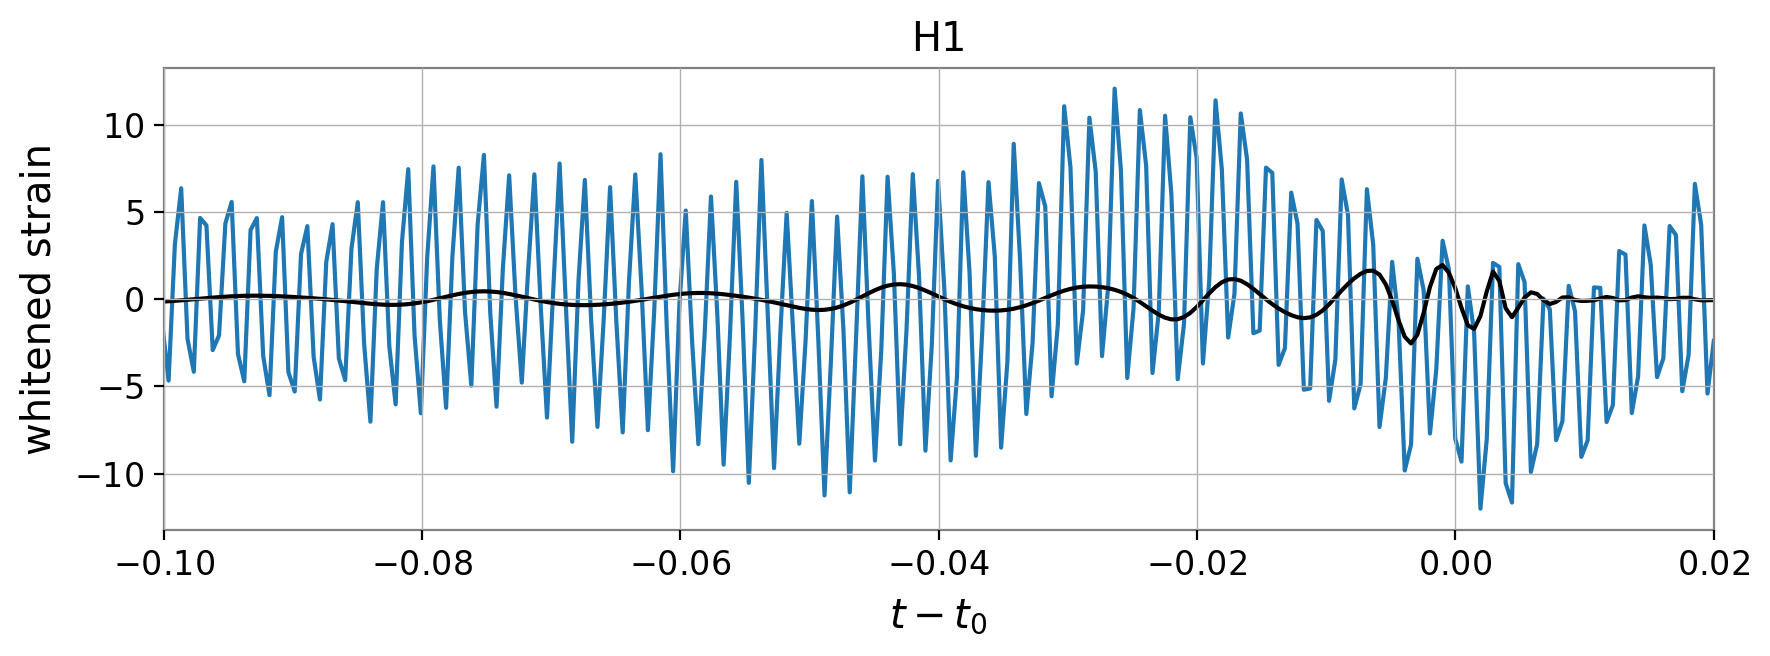

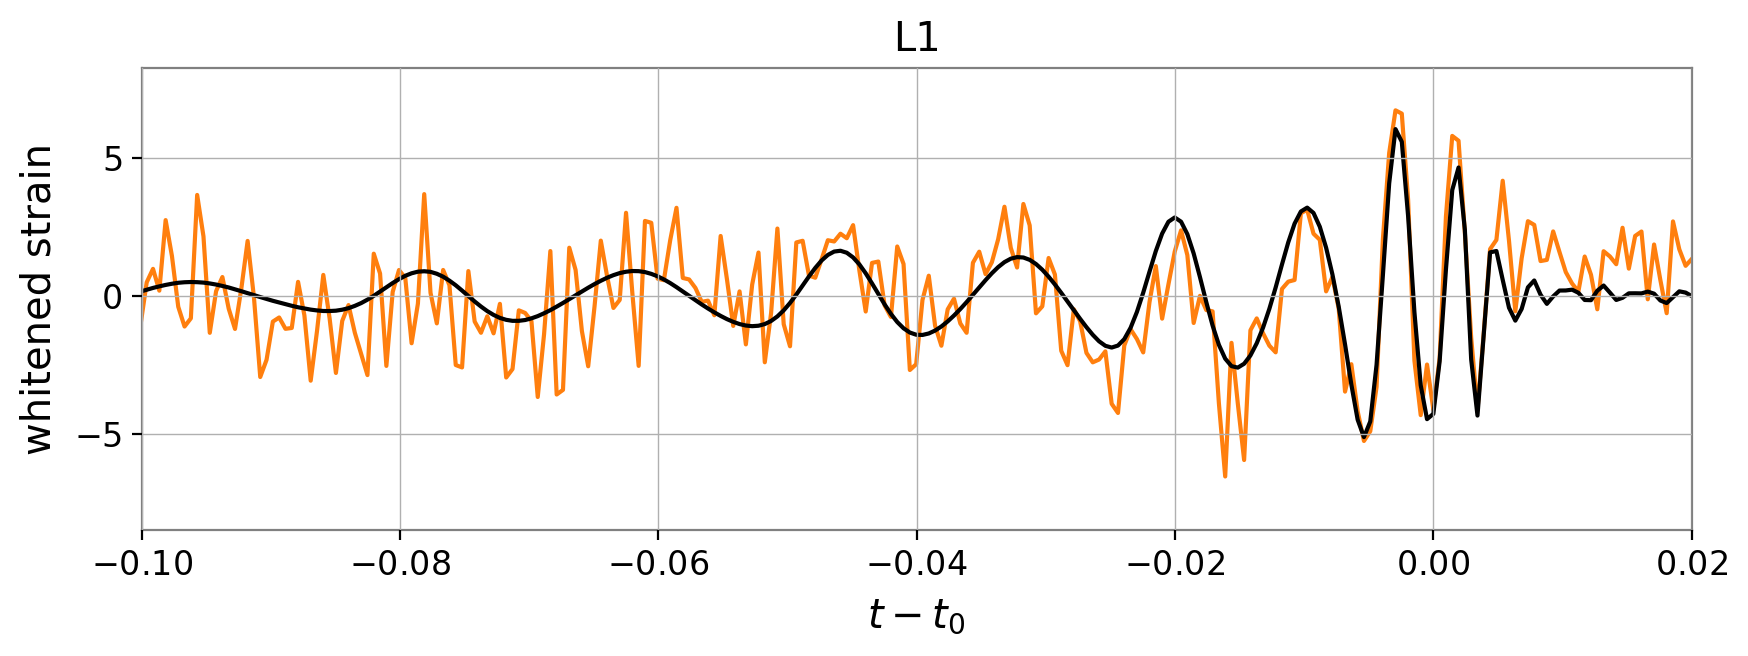

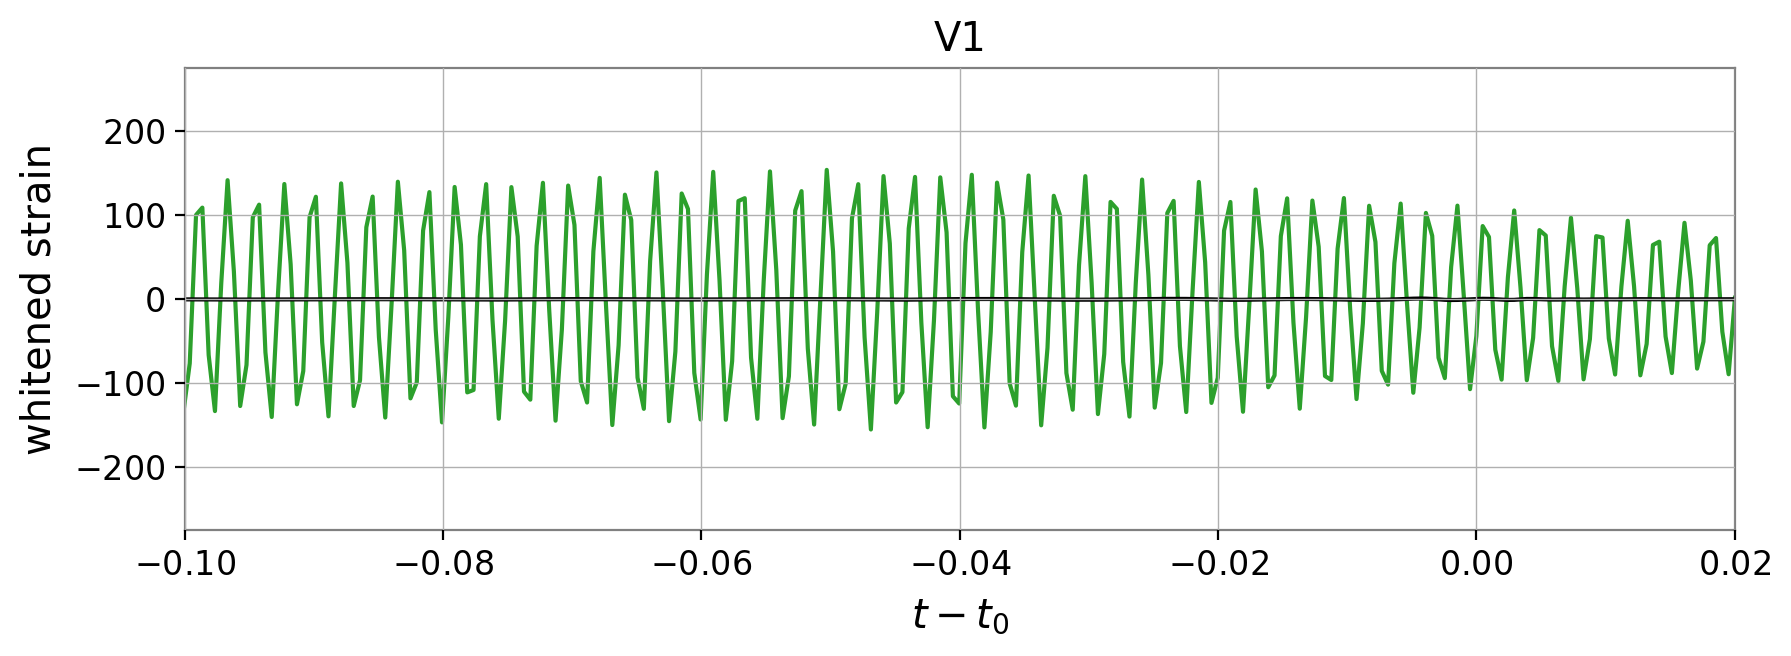

In [5]:
# Plot
for i, ifo in enumerate(lm.ifos): 

    times = lm.time_dict[ifo] - lm.reference_time - dt_dict[ifo]

    plt.figure(figsize=(10, 3))

    plt.plot(times, whitened_strain_td[ifo]['strain'], color=f'C{i}')
    plt.plot(times, whitened_strain_td[ifo]['inj'], color='k')
    
    plt.title(ifo)
    plt.xlabel('$t - t_0$')
    plt.ylabel('whitened strain')
    plt.xlim(-0.1, 0.02)
    plt.show()

Something looks extremely wrong... There seems to be an issue at around 500 Hz for H1, 14 Hz for L1, and 450 Hz for V1 (by counting cycles).  

### Load in the time-domain data from the `.gwf` file

In [6]:
# load in the metadata
with open('meta.json') as f:
    metadata = json.load(f)
    
# get the strain data
strain_filesnames = {ifo:metadata[ifo]['filename'] for ifo in lm.ifos}
channels = {ifo:metadata[ifo]['channel'] for ifo in lm.ifos}

gwf_data_dict = {}

for ifo in lm.ifos:  

    # copy from CIT
    fname = strain_filesnames[ifo]
    
    # load in strain data from gwf
    gwf_data = TimeSeries.read(os.path.basename(fname), channels[ifo])
    
    # convert to a dictionary
    gwf_data_dict[ifo] = {'strain':gwf_data.value, 'times':gwf_data.times.value}

duration: 1183.9999389648438


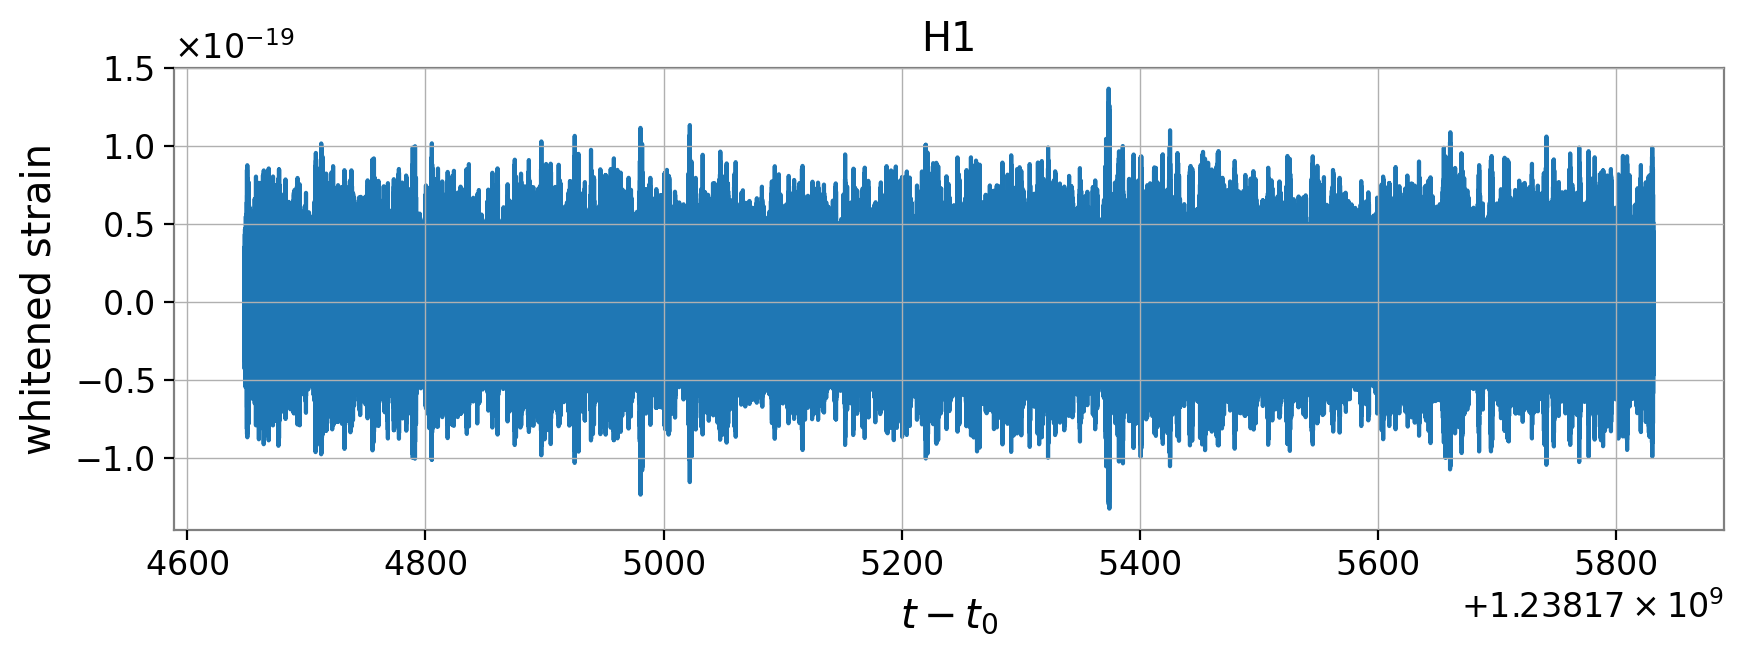

duration: 1183.9999389648438


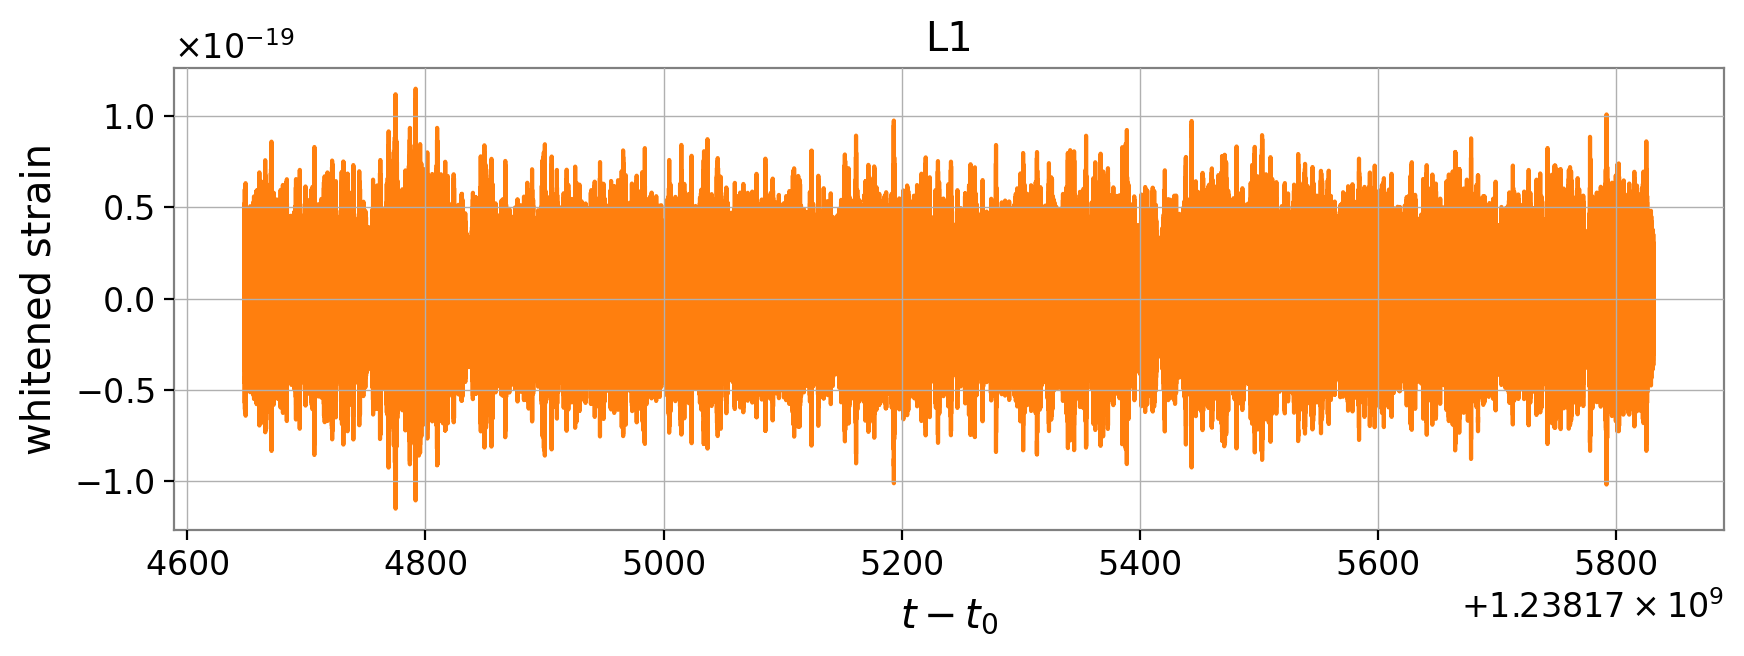

duration: 1183.9999389648438


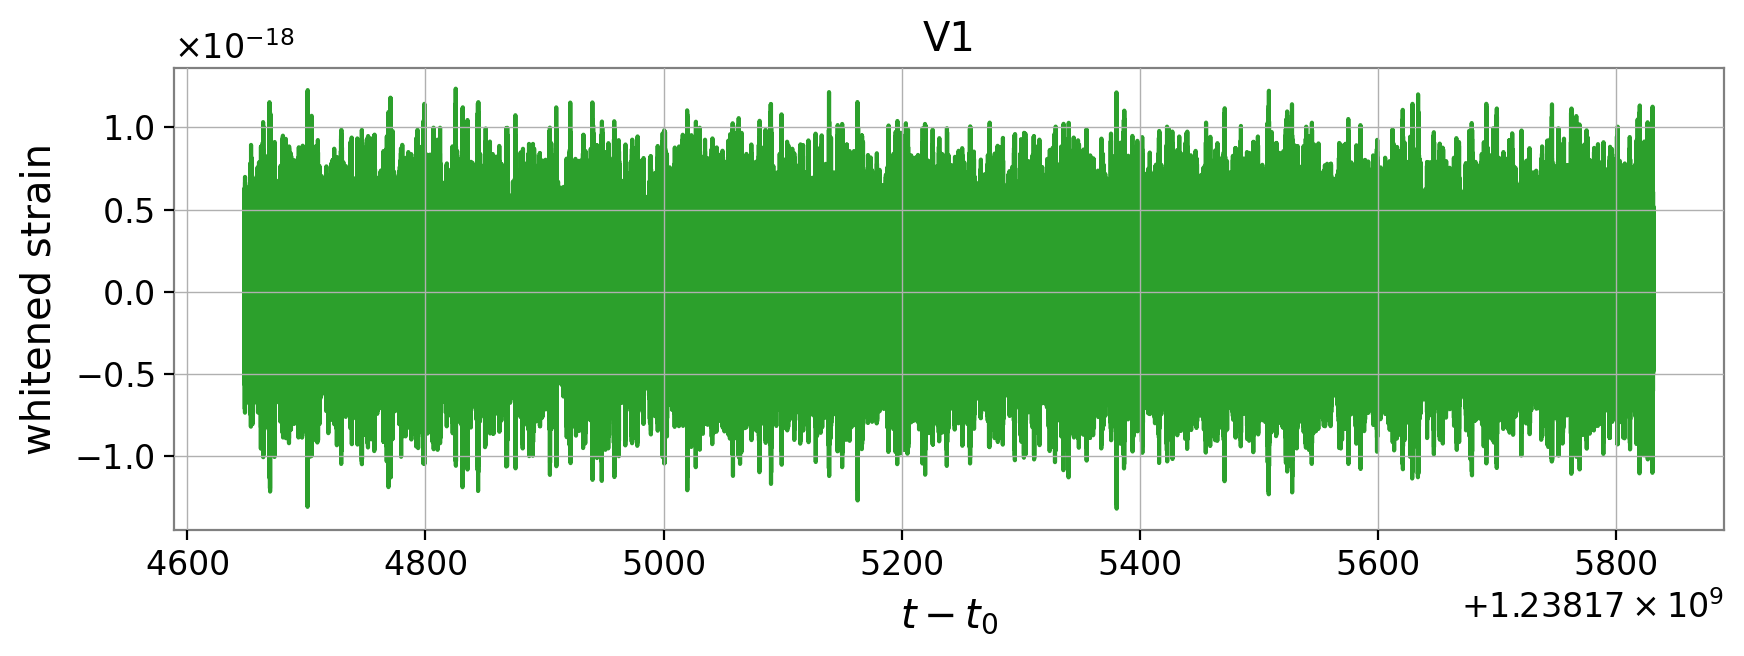

In [7]:
# Plot the gwf files
for i, ifo in enumerate(lm.ifos): 
 
    plt.figure(figsize=(10, 3))

    print('duration:', gwf_data_dict[ifo]['times'][-1] - gwf_data_dict[ifo]['times'][0])

    plt.plot(gwf_data_dict[ifo]['times'], gwf_data_dict[ifo]['strain'], color=f'C{i}')
    
    plt.title(ifo)
    plt.xlabel('$t - t_0$')
    plt.ylabel('whitened strain')
    plt.show()

### Generate Welch PSDs from the strain

In [8]:
# Generate welch PSDs
welch_psds = {}

for i, ifo in enumerate(lm.ifos): 

    data  = gwf_data_dict[ifo]['strain']
    times = gwf_data_dict[ifo]['times']

    # fs is the sampling frequency, i.e., 1/delta_t
    delta_t = np.unique(np.diff(times))
    fs = 1/delta_t[0]
    
    kws = dict(nperseg=8*fs, average='median')
    freq, psd = sig.welch(data, fs=fs, **kws)

    welch_psds[ifo] = np.transpose([freq, psd])

In [9]:
ACF_welch, welch_psds_cond = utils.get_ACF(
    welch_psds,  ## Pass the welch PSDs here to generate a new ACF
    lm.time_dict, 
    f_low=lm.f_low, 
    f_max=lm.f_max,
    return_psds=True
)

[0.25 0.25 0.25 ... 0.25 0.25 0.25]
[0.125 0.125 0.125 ... 0.125 0.125 0.125]
[0.25 0.25 0.25 ... 0.25 0.25 0.25]
[0.125 0.125 0.125 ... 0.125 0.125 0.125]
[0.5 0.5 0.5 ... 0.5 0.5 0.5]
[0.125 0.125 0.125 ... 0.125 0.125 0.125]


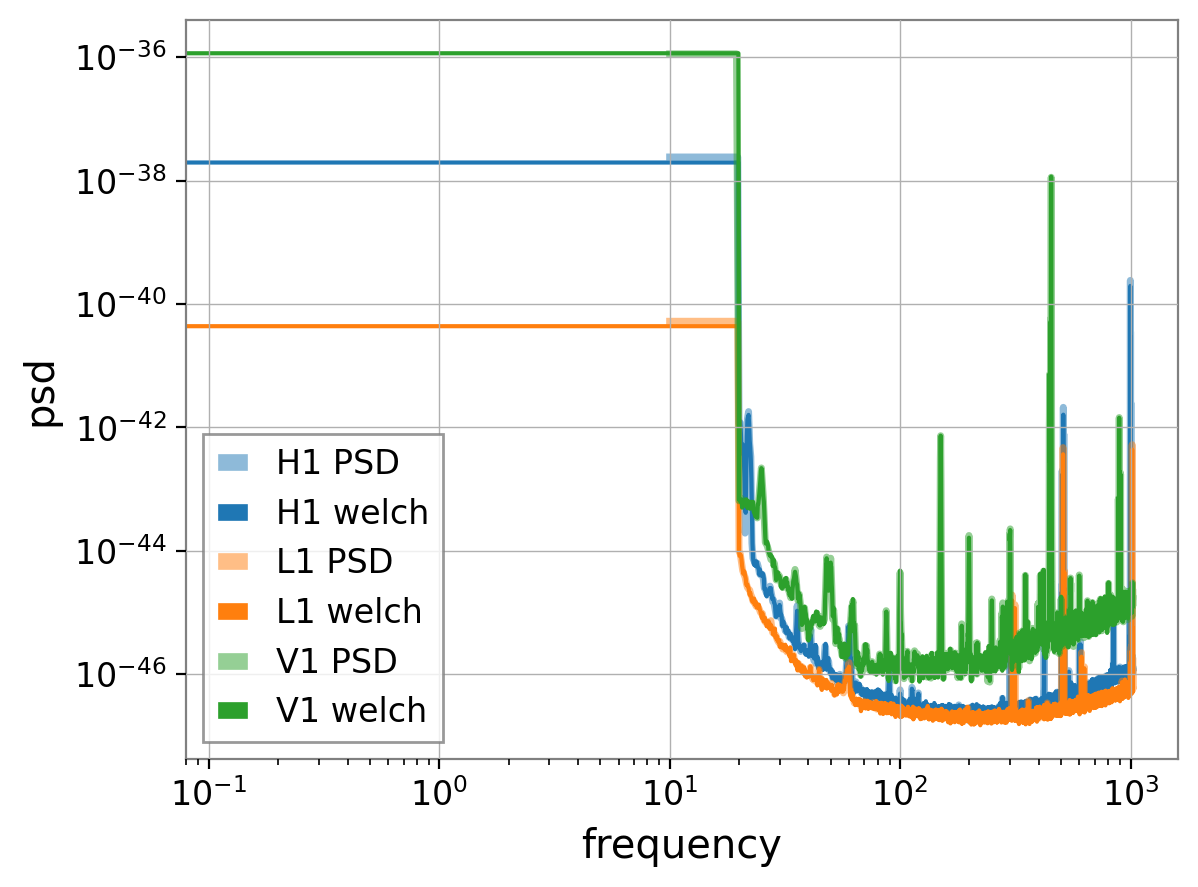

In [10]:
# Plot a comparison
plt.figure()
for i, ifo in enumerate(lm.ifos): 
    
    freq, psd = lm.conditioned_psd_dict[ifo].transpose()
    plt.loglog(freq, psd, color=f'C{i}', alpha=0.5, lw=2.5, label=ifo+' PSD')

    freq_welch, psd_welch = welch_psds_cond[ifo].transpose()
    plt.loglog(freq_welch, psd_welch, color=f'C{i}', label=ifo+' welch')

    print(np.diff(freq))
    print(np.diff(freq_welch))

plt.xlabel('frequency')
plt.ylabel('psd')
plt.legend()
#plt.xlim(10,1024)
#plt.ylim(1e-47,1e-37)
plt.show()

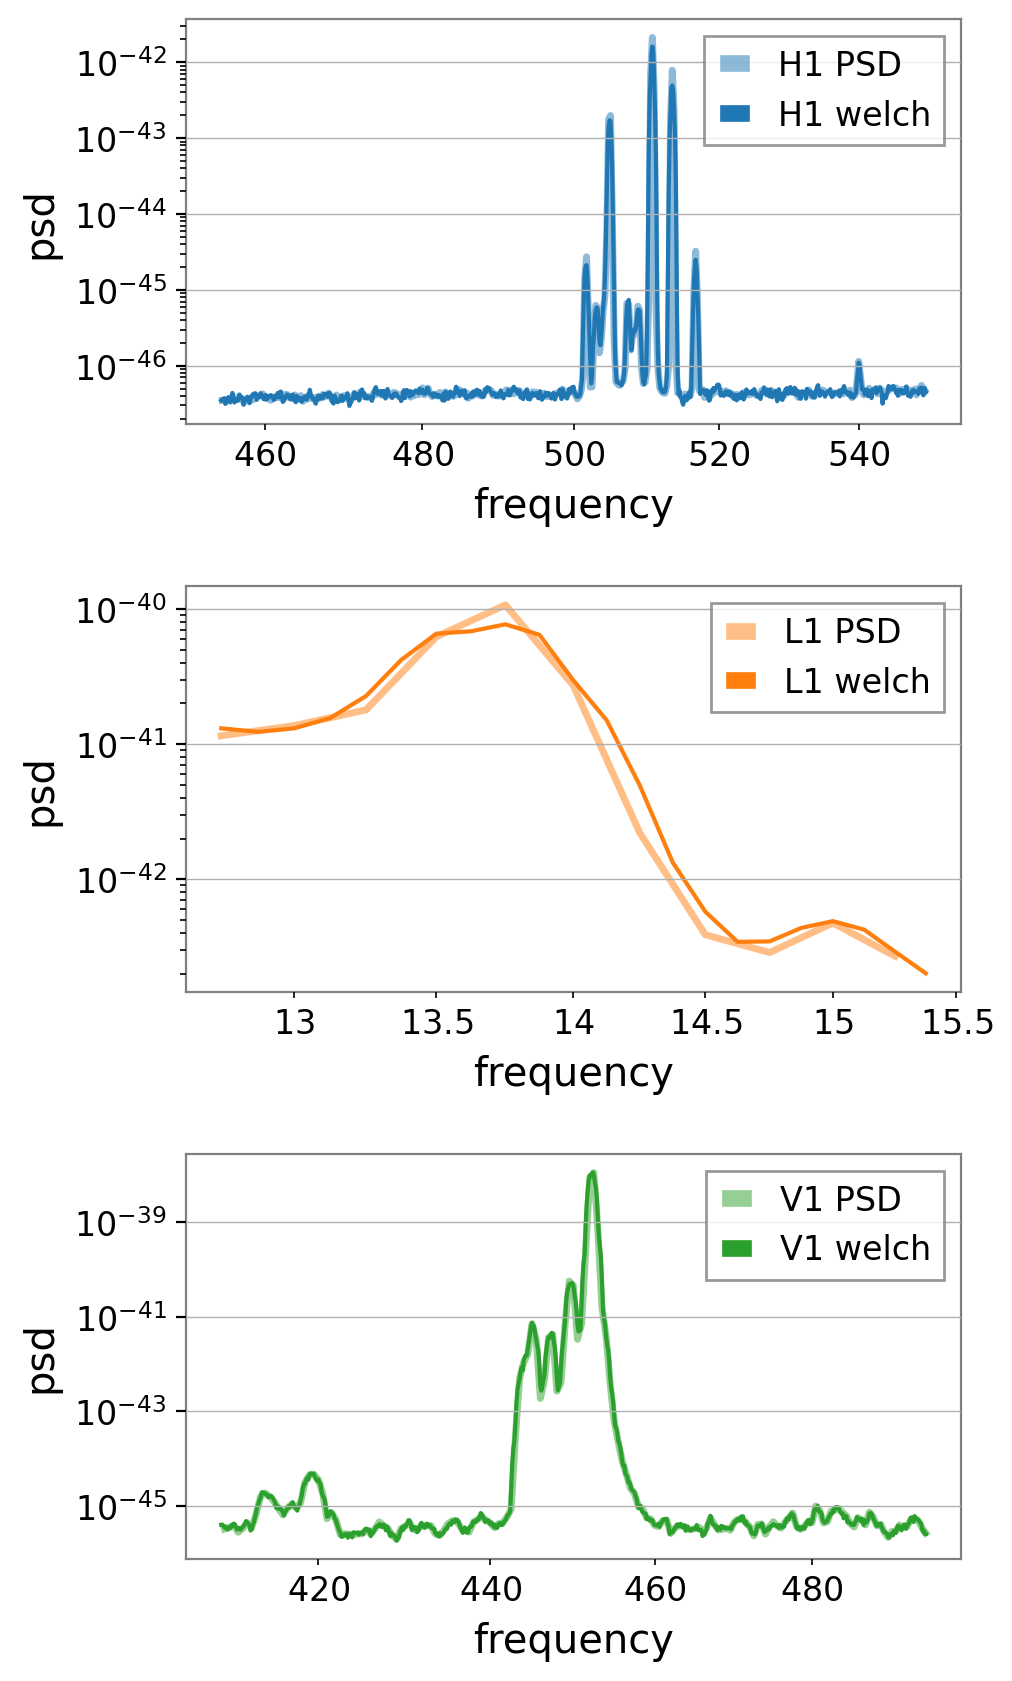

In [11]:
# Zoom in at certain frequency ranges
fig, axes = plt.subplots(3,1, figsize=(5,10))

freq_weird = [500,14,450]

for i, (ifo, ax, f) in enumerate(zip(lm.ifos, axes, freq_weird)): 

    freq_bounds = [f/1.1, 1.1*f]
    
    freq, psd = lm.psd_dict[ifo].transpose()
    m = (freq > freq_bounds[0]) & (freq < freq_bounds[1])
    ax.loglog(freq[m], psd[m], color=f'C{i}', alpha=0.5, lw=2.5, label=ifo+' PSD')

    freq_welch, psd_welch = welch_psds[ifo].transpose()
    m = (freq_welch > freq_bounds[0]) & (freq_welch < freq_bounds[1])
    ax.loglog(freq_welch[m], psd_welch[m], color=f'C{i}', label=ifo+' welch')

    ax.legend()
    ax.set_ylabel('psd')
    ax.set_xlabel('frequency')

plt.subplots_adjust(hspace=0.4)
plt.show()

Apply whitening

In [12]:
# Whiten with the Welch PSDs
whitened_strain_td_welch = {}
for i, ifo in enumerate(lm.ifos): 

    # Get whitened strain 
    C = sl.toeplitz(ACF_welch[ifo])
    L = sl.cholesky(C,lower=True)
    wh_strain = sl.solve_triangular(L, lm.data_dict[ifo], lower=True)
    wh_inj = sl.solve_triangular(L, injection_dict[ifo], lower=True)

    whitened_strain_td_welch[ifo] = {'strain':wh_strain, 'inj':wh_inj}

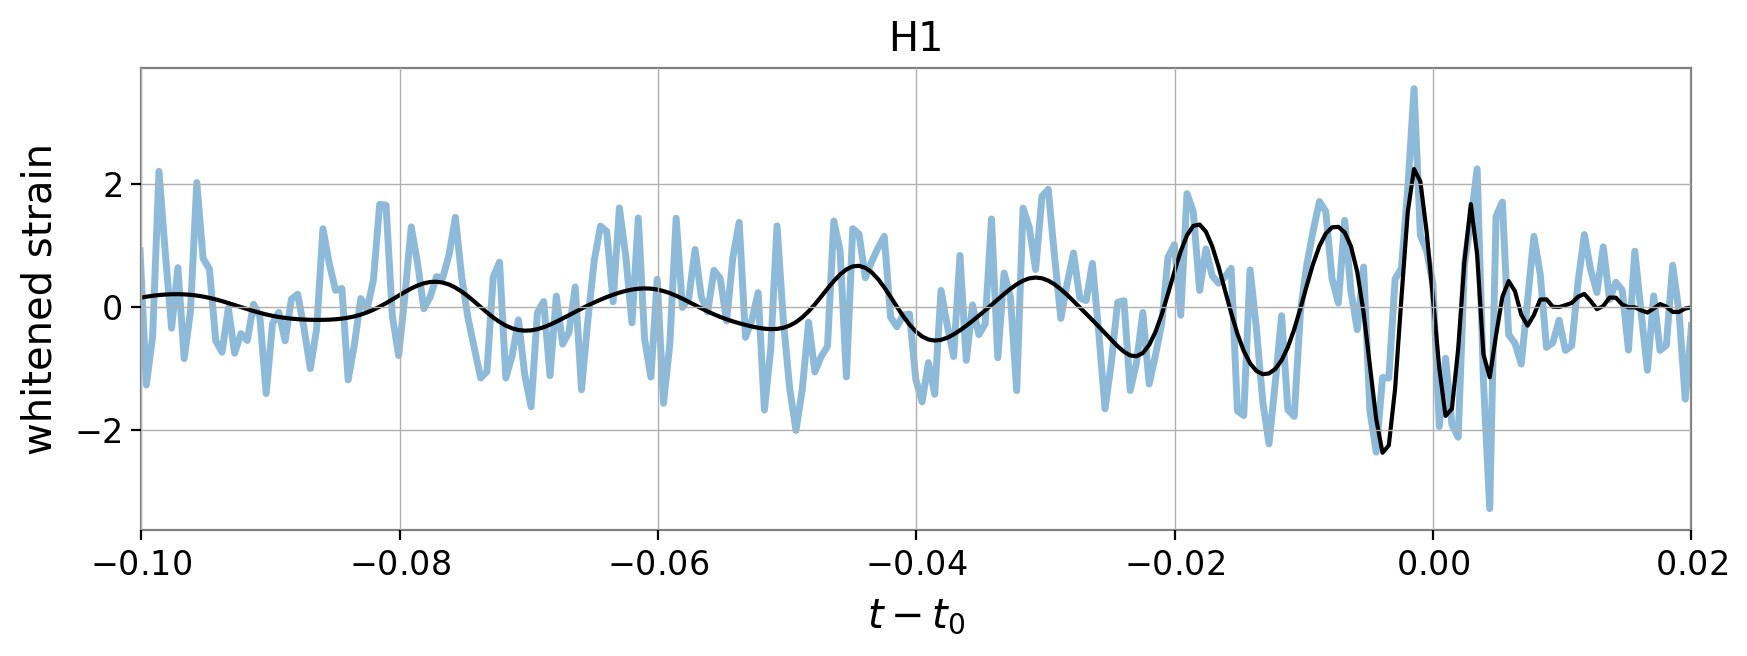

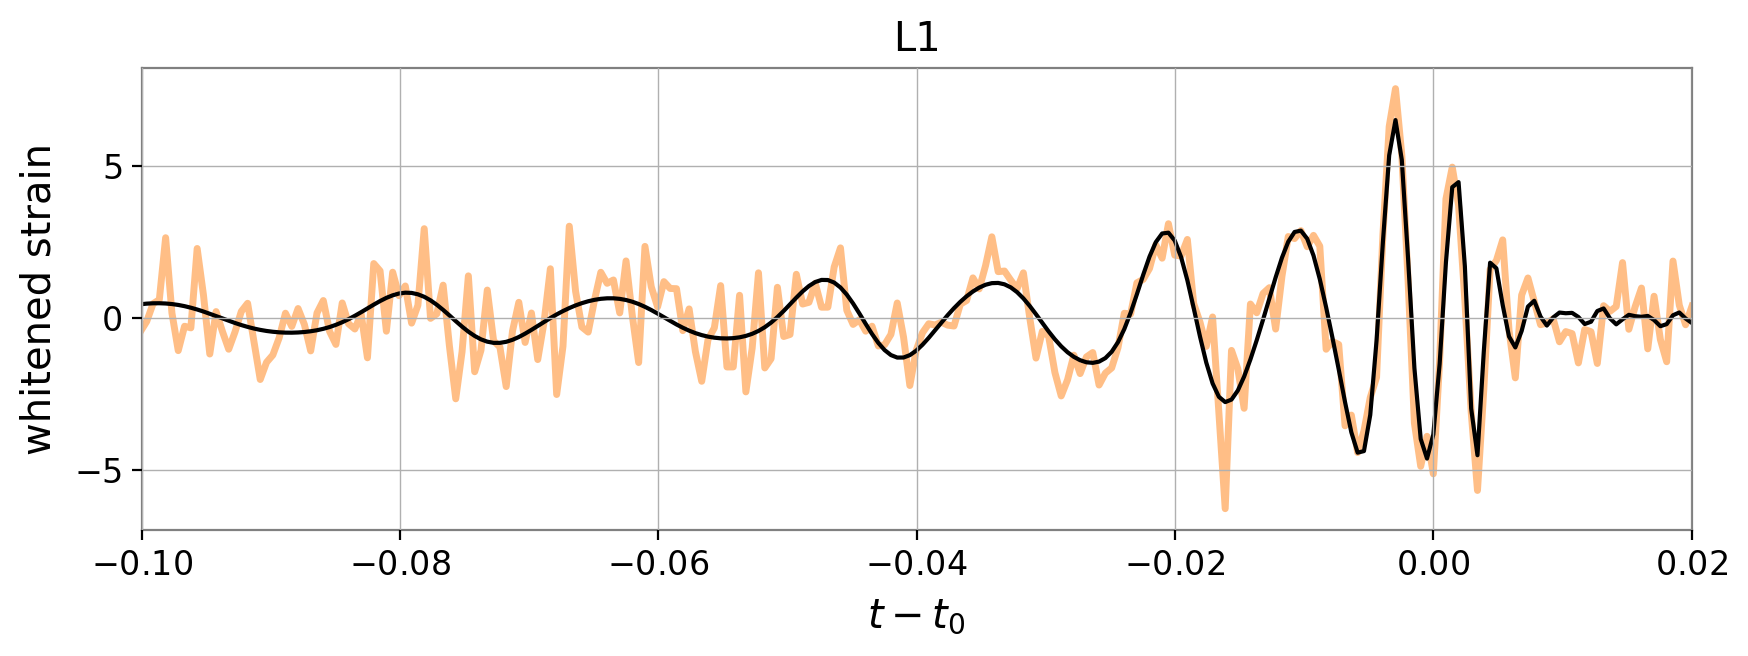

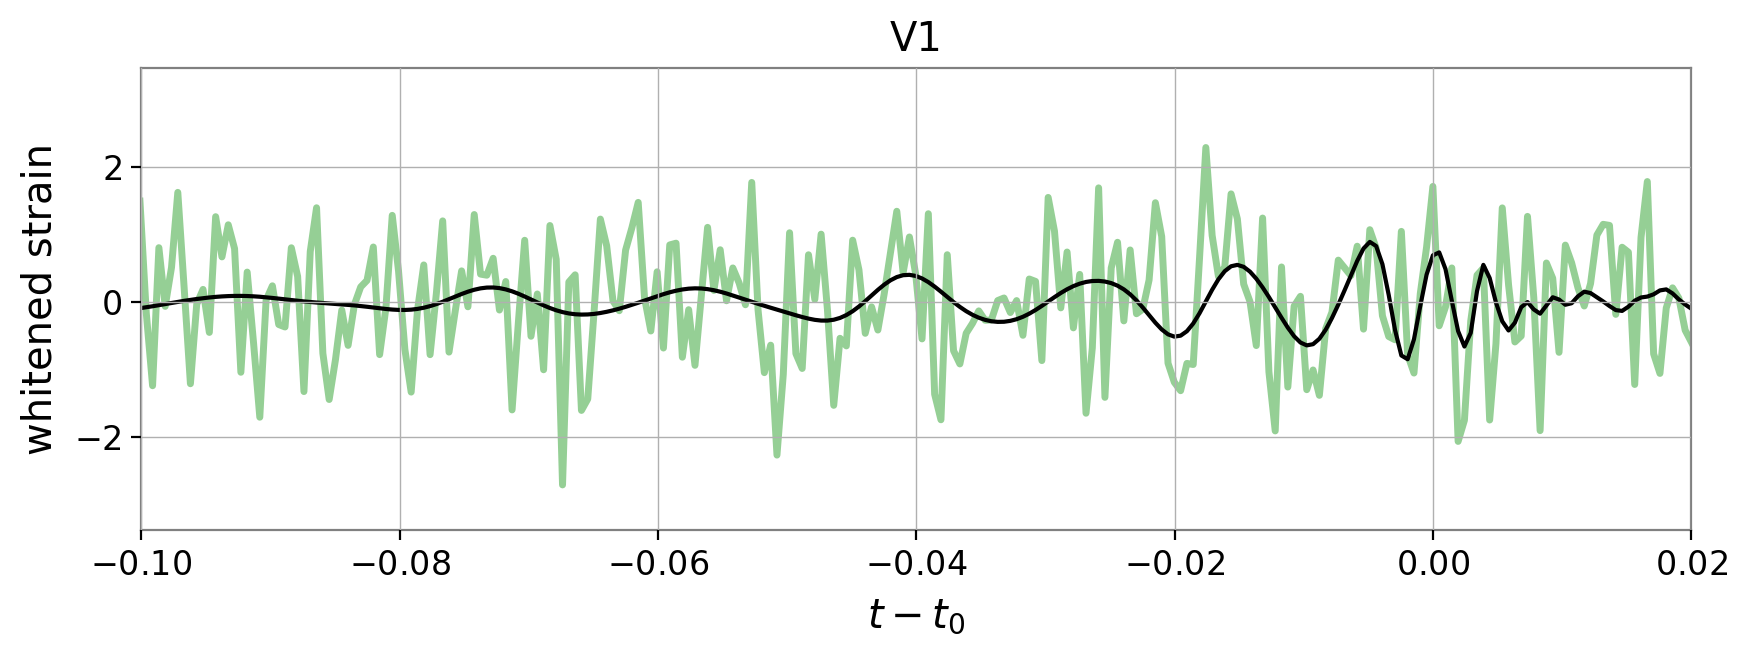

In [13]:
# Plot
for i, ifo in enumerate(lm.ifos): 

    times = lm.time_dict[ifo] - lm.reference_time - dt_dict[ifo]

    plt.figure(figsize=(10, 3))

    plt.plot(times, whitened_strain_td_welch[ifo]['strain'], color=f'C{i}', lw=2.5, alpha=0.5)
    plt.plot(times, whitened_strain_td_welch[ifo]['inj'], color='k')
    
    plt.title(ifo)
    plt.xlabel('$t - t_0$')
    plt.ylabel('whitened strain')
    plt.xlim(-0.1, 0.02)
    #plt.ylim(-10,10)
    plt.show()

Looks good!

In [14]:
for ifo in lm.ifos: 
    savepath = f"{ifo}_PSD_WELCH.txt"
    if not os.path.exists(savepath):
        np.savetxt(savepath, welch_psds[ifo])
        print(f'saved at {savepath}!')
    else: 
        print('already saved!')

already saved!
already saved!
already saved!


Also compare the ACFs directly:

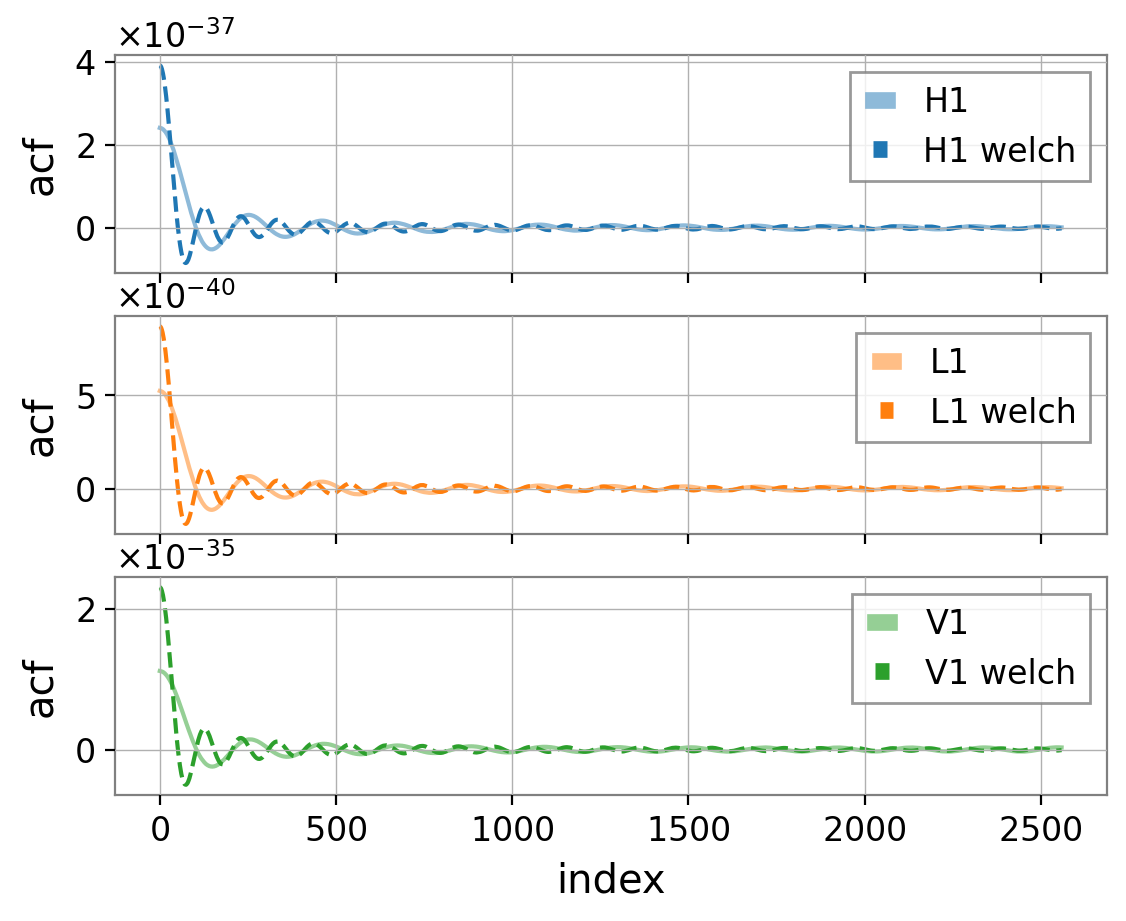

In [15]:
fig, axes = plt.subplots(3,1, sharex=True)

for i, (ifo, ax) in enumerate(zip(lm.ifos, axes)): 
    
    ax.plot(lm.rho_dict[ifo], color=f'C{i}', alpha=0.5, label=ifo)
    ax.plot(ACF_welch[ifo], color=f'C{i}', ls='--', label=ifo+' welch')
    ax.legend()
    ax.set_ylabel('acf')

axes[-1].set_xlabel('index')
plt.show()

They seems weird ... we figured out that this is because the PSD provided by bilby does not go all the way down to $f=0$ Hz.

### Make the provided bilby PSD extend down to $f=0$ Hz

9.75 10.0
9.75 10.0
9.5 10.0


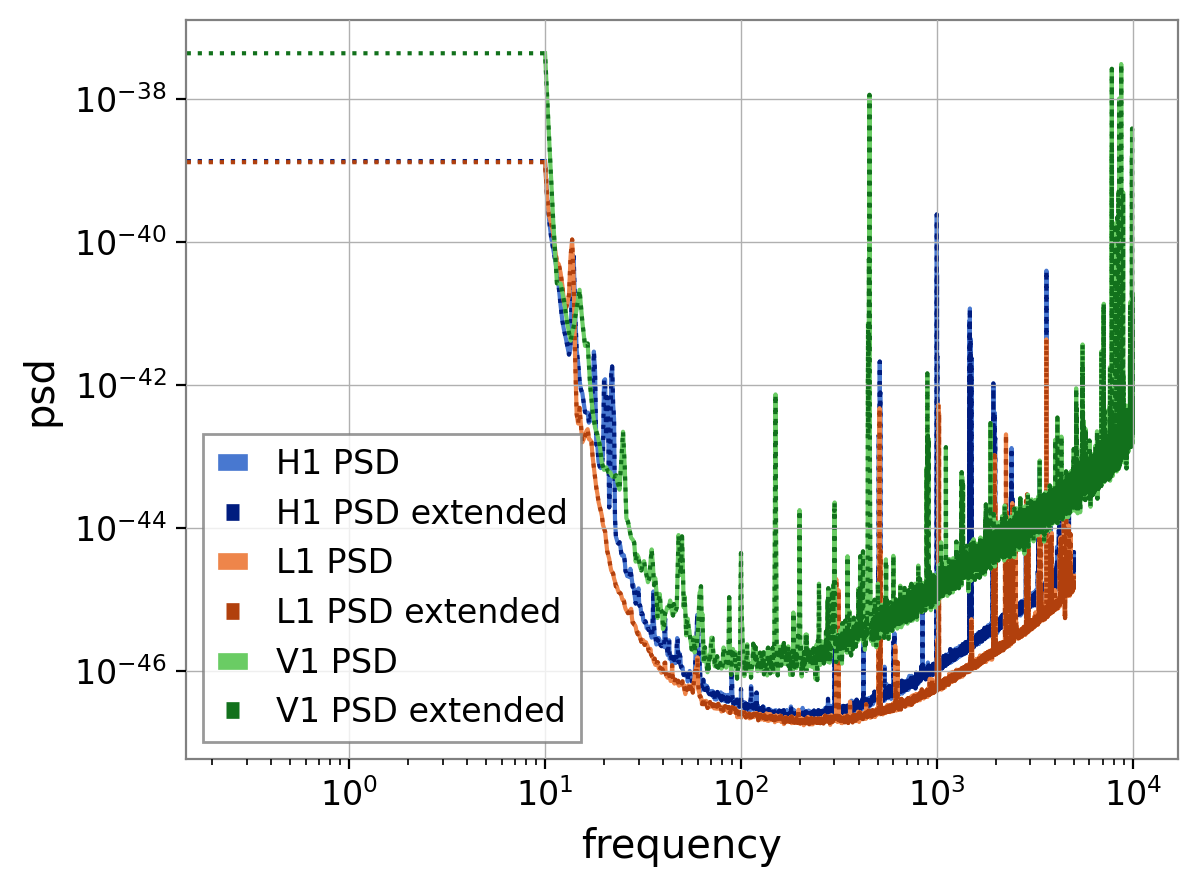

In [16]:
import seaborn as sns
cmap1 = sns.color_palette('muted')
cmap2 = sns.color_palette('dark')

extended_psd_dict = {}

for i, ifo in enumerate(lm.ifos): 
    
    freq, psd = lm.psd_dict[ifo].transpose()

    plt.loglog(freq, psd, color=cmap1[i], label=ifo+' PSD')

    df = freq[1] - freq[0]
    
    additional_freqs = np.arange(0,freq[0],df)
    additional_psds = np.ones(len(additional_freqs))*psd[0]

    print(additional_freqs[-1], freq[0])

    freq = np.concatenate([additional_freqs, freq])
    psd = np.concatenate([additional_psds, psd])

    plt.loglog(freq, psd, color=cmap2[i], ls=':', label=ifo+' PSD extended')

    extended_psd_dict[ifo] = np.transpose([freq, psd])

plt.xlabel('frequency')
plt.ylabel('psd')
plt.legend()
plt.show()

In [17]:
# Get the ACFs 
ACF, psds_cond = utils.get_ACF(
    extended_psd_dict,
    lm.time_dict, 
    f_low=lm.f_low, 
    f_max=lm.f_max,
    return_psds=True
)

# Whiten with the extended PSDs
whitened_strain_td_ext = {}
for i, ifo in enumerate(lm.ifos): 

    # Get whitened strain 
    C = sl.toeplitz(ACF[ifo])
    L = sl.cholesky(C,lower=True)
    wh_strain = sl.solve_triangular(L, lm.data_dict[ifo], lower=True)
    wh_inj = sl.solve_triangular(L, injection_dict[ifo], lower=True)

    whitened_strain_td_ext[ifo] = {'strain':wh_strain, 'inj':wh_inj}

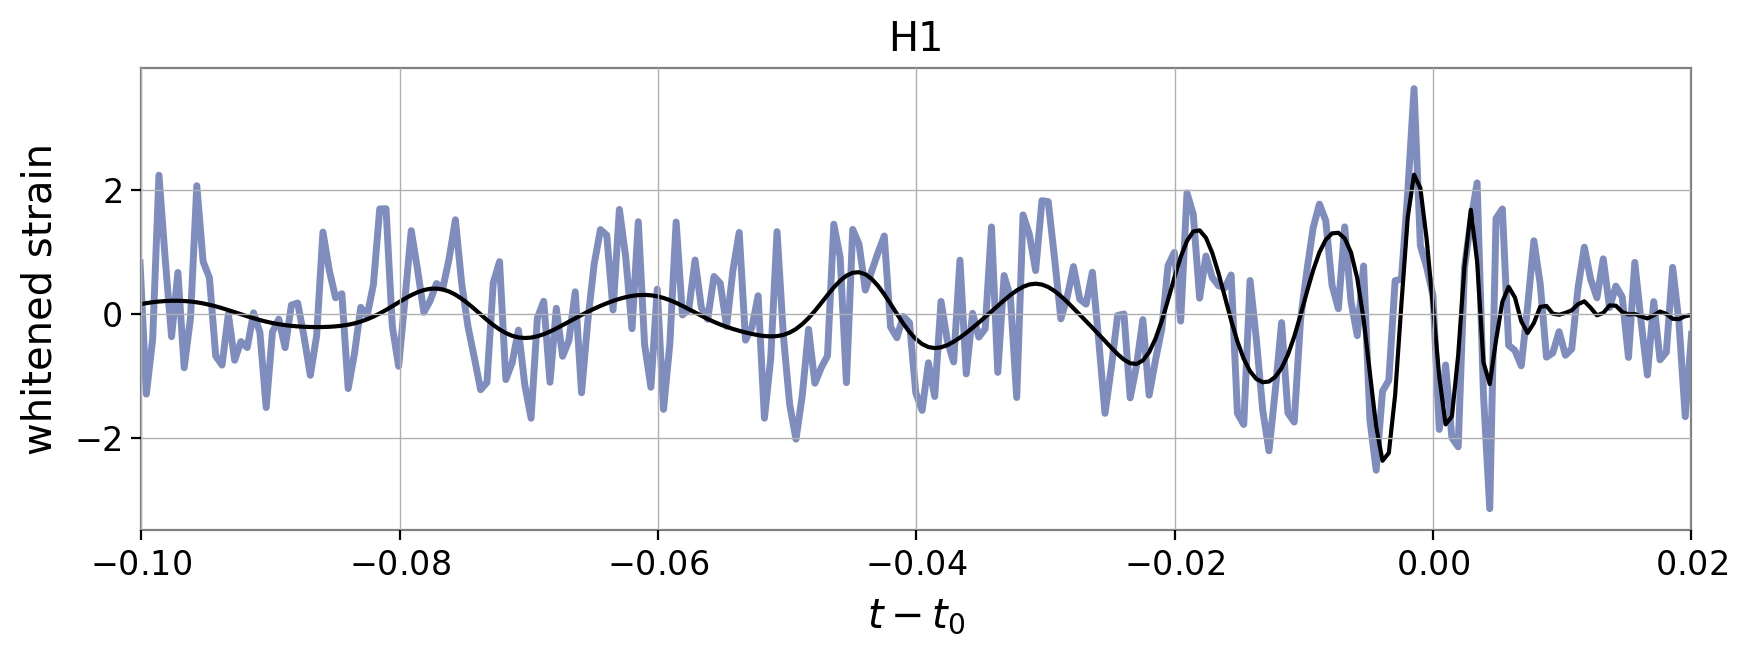

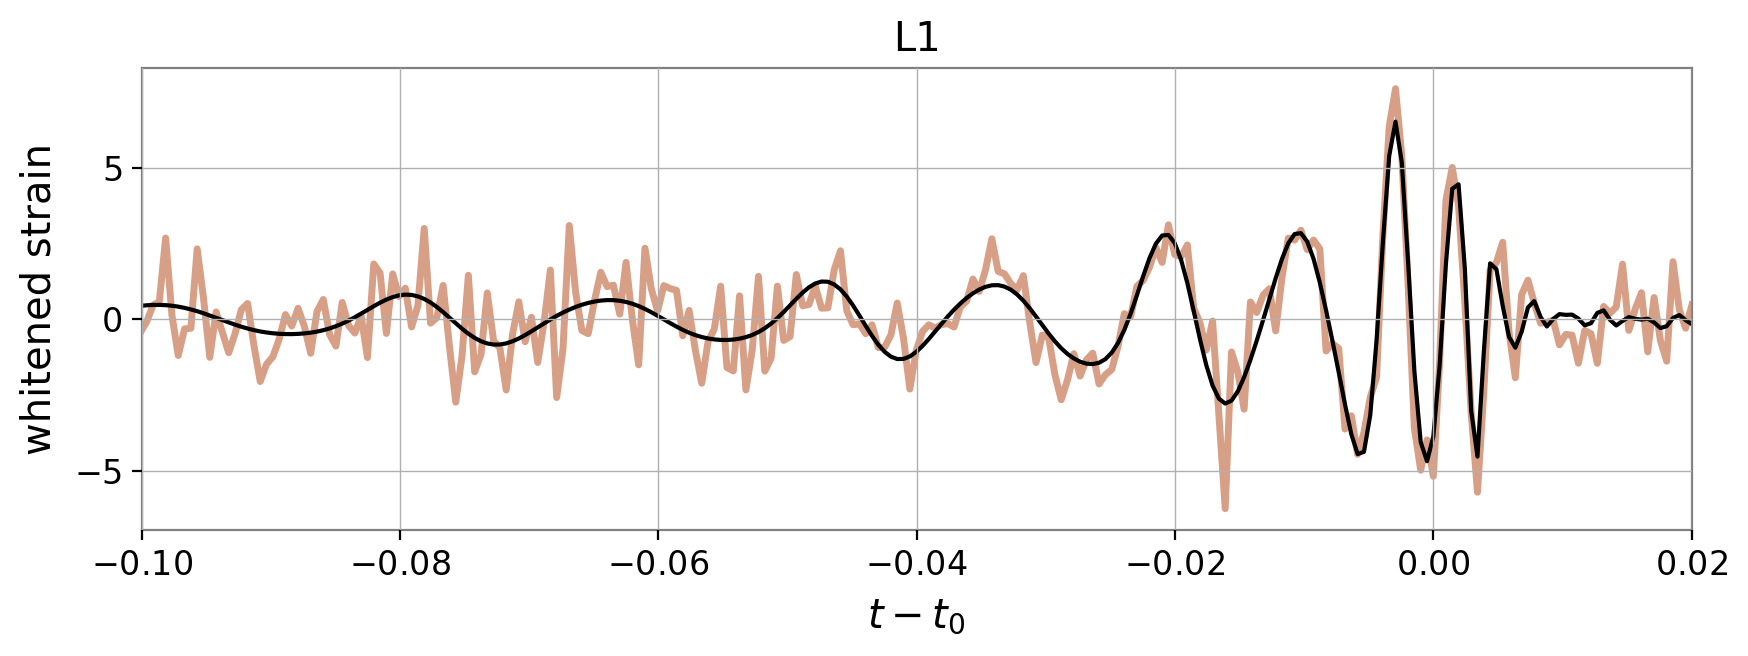

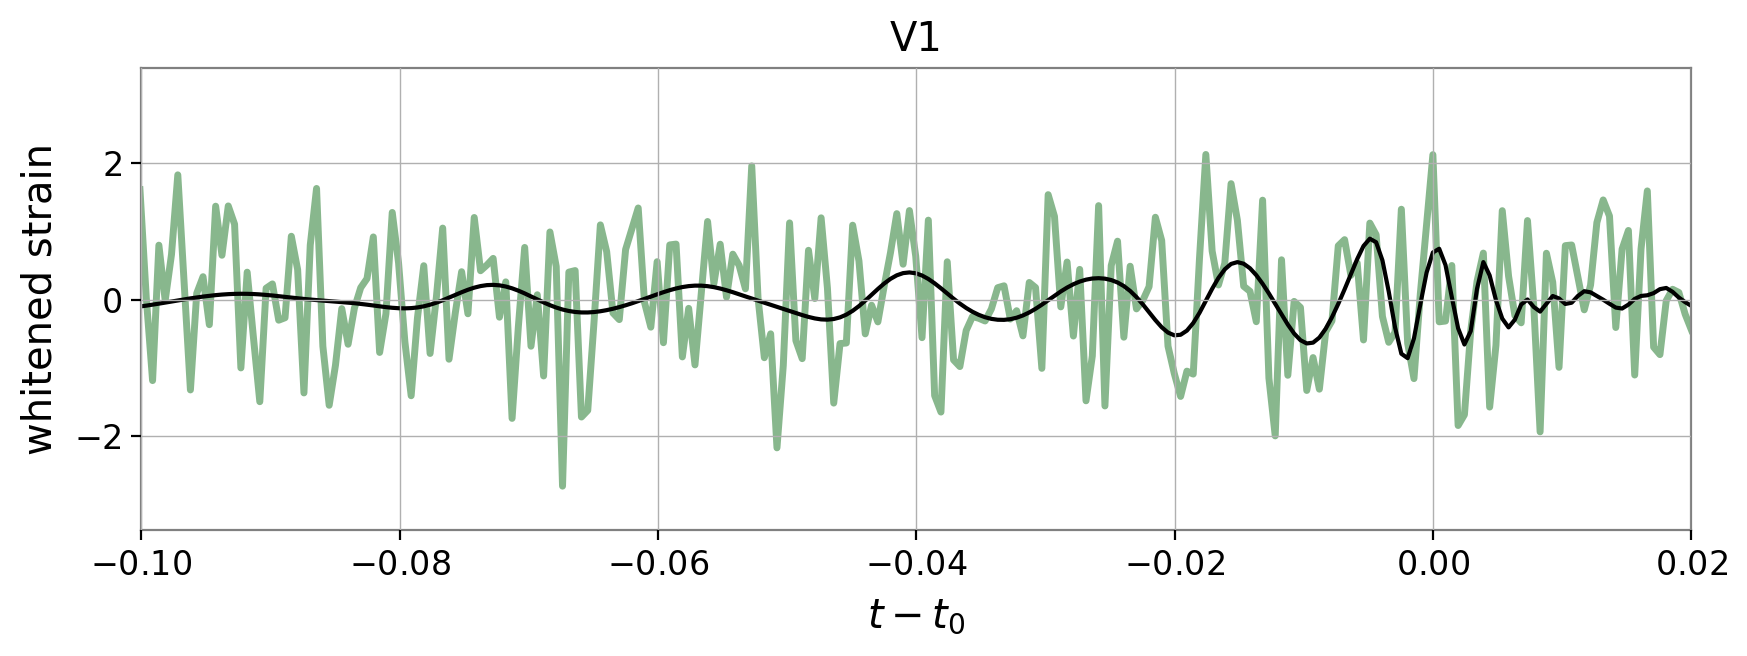

In [18]:
# Plot
for i, ifo in enumerate(lm.ifos): 

    times = lm.time_dict[ifo] - lm.reference_time - dt_dict[ifo]

    plt.figure(figsize=(10, 3))

    plt.plot(times, whitened_strain_td_ext[ifo]['strain'], color=cmap2[i], alpha=0.5, lw=2.5)
    plt.plot(times, whitened_strain_td_ext[ifo]['inj'], color='k')
    
    plt.title(ifo)
    plt.xlabel('$t - t_0$')
    plt.ylabel('whitened strain')
    plt.xlim(-0.1, 0.02)
    #plt.ylim(-10,10)
    plt.show()

In [19]:
# Save
for ifo in lm.ifos: 
    savepath = f"{ifo}_PSD_EXTENDED.txt"
    if not os.path.exists(savepath):
        np.savetxt(savepath, extended_psd_dict[ifo])
        print(f'saved at {savepath}!')
    else: 
        print('already saved!')

already saved!
already saved!
already saved!


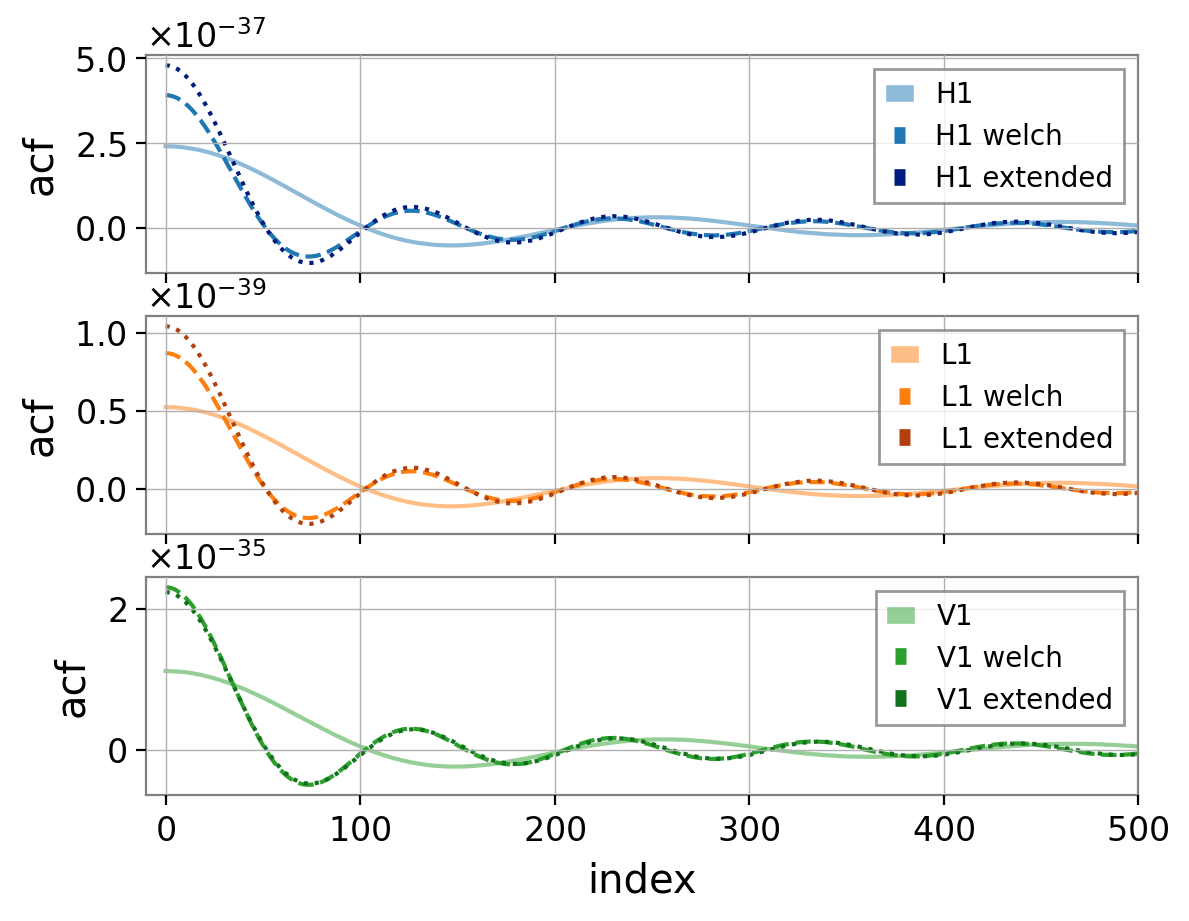

In [20]:
fig, axes = plt.subplots(3,1, sharex=True)

for i, (ifo, ax) in enumerate(zip(lm.ifos, axes)): 
    
    ax.plot(lm.rho_dict[ifo], color=f'C{i}', alpha=0.5, label=ifo)
    ax.plot(ACF_welch[ifo], color=f'C{i}', ls='--', label=ifo+' welch')
    ax.plot(ACF[ifo], color=cmap2[i], ls=':', label=ifo+' extended')

    ax.legend(loc='upper right', fontsize=10)
    ax.set_ylabel('acf')
    ax.set_xlim(-10,500)

axes[-1].set_xlabel('index')
plt.show()